In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
#import seaborn as sns
import torch.nn as nn
import torch
import os
#import math
#import pandas as pd
#from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
#from torchvision import transforms, utils
import pickle
import torchvision
from torch.optim import SGD, Adam
from crp.image import imgify, vis_opaque_img, plot_grid
from random import random

#from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat

from crp.concepts import ChannelConcept
from crp.helper import get_layer_names, get_output_shapes
from crp.cache import ImageCache
from crp.attribution import CondAttribution
from crp.visualization import FeatureVisualization
#from torch.autograd import Variable

from tqdm import tqdm 
from PIL import Image
import numpy as np

import tigramite
from tigramite import data_processing as pp
#from tigramite.toymodels import structural_causal_processes
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc_torch import GPDCtorch
from tigramite.independence_tests.cmiknn import CMIknn
#from tigramite.causal_effects import CausalEffects
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.regressionCI import RegressionCI

%matplotlib inline

In [3]:
from shape_covnet import ShapeConvolutionalNeuralNetwork, train_network
from causal_dsprites_dataset import get_datasets, CausalDSpritesDataset
from lingam import make_lingam
from cmiknnmixed import CMIknnMixed
%reload_ext autoreload
%autoreload 2

In [4]:
BATCH_SIZE = 128

datasets = get_datasets(BATCH_SIZE)
print(len(datasets["test_unbiased"]["ds"]))

watermark: 18680 of 245713, class 0 of shape
watermark: 228688 of 246475, class 1 of shape
watermark: 10805 of 245092, class 2 of shape
watermark: 42945 of 123041, class 0 of scale
watermark: 42818 of 122682, class 1 of scale
watermark: 43042 of 122732, class 2 of scale
watermark: 43046 of 122787, class 3 of scale
watermark: 43089 of 122519, class 4 of scale
watermark: 43233 of 123519, class 5 of scale
watermark: 6391 of 18496, class 0 of orientation
watermark: 6558 of 18578, class 1 of orientation
watermark: 6363 of 18368, class 2 of orientation
watermark: 6604 of 18434, class 3 of orientation
watermark: 6611 of 18594, class 4 of orientation
watermark: 6368 of 18669, class 5 of orientation
watermark: 6344 of 18359, class 6 of orientation
watermark: 6592 of 18443, class 7 of orientation
watermark: 6376 of 18397, class 8 of orientation
watermark: 6419 of 18423, class 9 of orientation
watermark: 6404 of 18452, class 10 of orientation
watermark: 6498 of 18474, class 11 of orientation
wate

In [5]:
model = train_network(datasets["train"]["loader"], BATCH_SIZE, load=True, path="watermark_dsprites.pickle")
[i.shape for i in model.parameters()]

[torch.Size([6, 1, 9, 9]),
 torch.Size([6]),
 torch.Size([6, 6, 9, 9]),
 torch.Size([6]),
 torch.Size([6, 384]),
 torch.Size([6]),
 torch.Size([3, 6]),
 torch.Size([3])]

In [ ]:
im_frame = Image.open( 'pxArt.png')
im_frame.thumbnail((64,64), Image.Resampling.LANCZOS)
im_frame = im_frame.convert("")
np_frame = torch.tensor(np.array(im_frame))
vals = np_frame[:,:,0]
vals = vals.view(1,64,64)
watermark_pixels = np.where(vals <= 100)
plt.imshow(vals[0], cmap="Greys")

In [6]:
# Feature Visualization:
#device = "cuda:0" if torch.cuda.is_available() else "cpu"
#canonizers = [SequentialMergeBatchNorm()]

composite = EpsilonPlusFlat()

cc = ChannelConcept()

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names }

attribution = CondAttribution(model, no_param_grad=True)

fv_path = "crp-stuff/dsprites-causal-unbiased-ds"
fv = FeatureVisualization(attribution, datasets["test_unbiased"]["ds"], layer_map, path=fv_path)
layer_names

['convolutional_layers.0',
 'convolutional_layers.2',
 'linear_layers.0',
 'linear_layers.2']

In [8]:
# RUN REFERENCE IMAGE COMPUTATION
saved_files = fv.run(composite, 0, len(datasets["test_unbiased"]["ds"]), 20, 100)

Running Analysis...


  0%|          | 0/15000 [00:00<?, ?it/s]

100%|██████████| 15000/15000 [08:23<00:00, 29.80it/s]


100%|██████████| 1800/1800 [00:00<00:00, 1939.99it/s]


In [7]:
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names}

cache = ImageCache(path="causal-unbiased-cache")

fv = FeatureVisualization(attribution, datasets["test_unbiased"]["ds"], layer_map, path=fv_path, cache=cache)


def vis_simple(data_batch, heatmaps, rf=False, alpha=1.0, vis_th=0.0, crop_th=0.0, kernel_size=9):
    return vis_opaque_img(data_batch, heatmaps, rf=False,alpha=1.0, vis_th=0.0, crop_th=0.0, kernel_size=9)


layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
output_shape = get_output_shapes(model, fv.get_data_sample(0)[0], layer_names)
layer_id_map = {l_name: np.arange(0, out[0]) for l_name, out in output_shape.items()}

fv.precompute_ref(layer_id_map,  plot_list=[vis_simple], mode="relevance", r_range=(0, 10),
                  composite=composite, batch_size=32, stats=True)

Layer: convolutional_layers.0


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 11.43it/s]


Layer: convolutional_layers.2


100%|██████████| 6/6 [00:00<00:00, 11.26it/s]


Layer: linear_layers.0


100%|██████████| 6/6 [00:00<00:00,  9.91it/s]


Layer: linear_layers.2


100%|██████████| 3/3 [00:00<00:00, 11.17it/s]


/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/crp/image.py:288: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


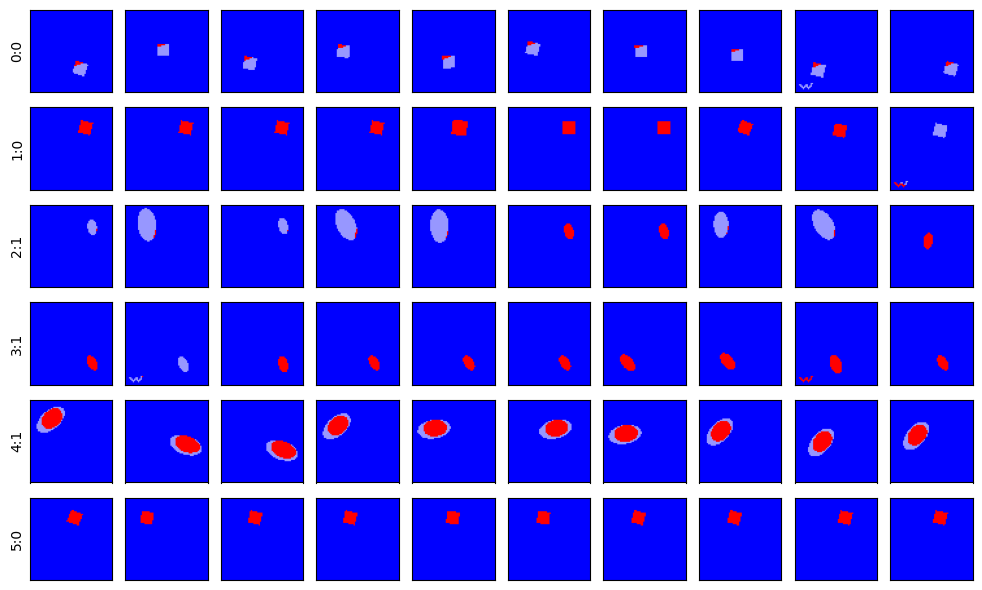

In [7]:
def make_all_relevances(cond_layer, neurons):
    all_refs = {}
    for i in neurons:
        targets, rel = fv.compute_stats(i, cond_layer, "relevance", top_N=1, norm=True)
        ref_c = fv.get_stats_reference(
            i,
            cond_layer,
            [targets],
            "relevance",
            (0, 10),
            composite=composite,
            rf=False,
            plot_fn=vis_opaque_img,
        )
        all_refs[f"{i}:{targets}"] = ref_c[f"{i}:{targets}"]
    plot_grid(all_refs, figsize=(10, len(neurons)), padding=False, symmetric=True)


make_all_relevances("convolutional_layers.0", range(6))

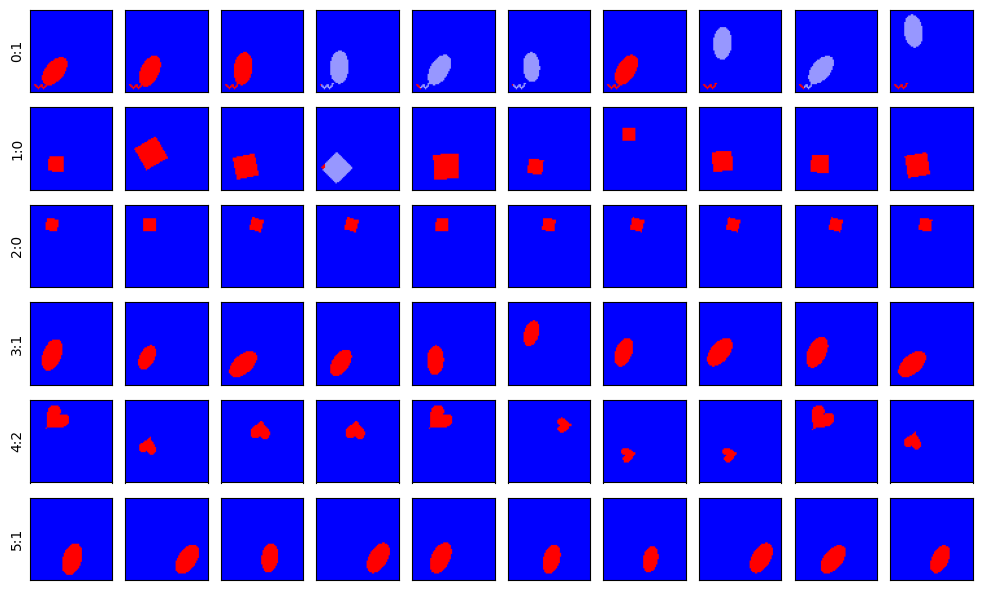

In [11]:
make_all_relevances("convolutional_layers.2",range(6))

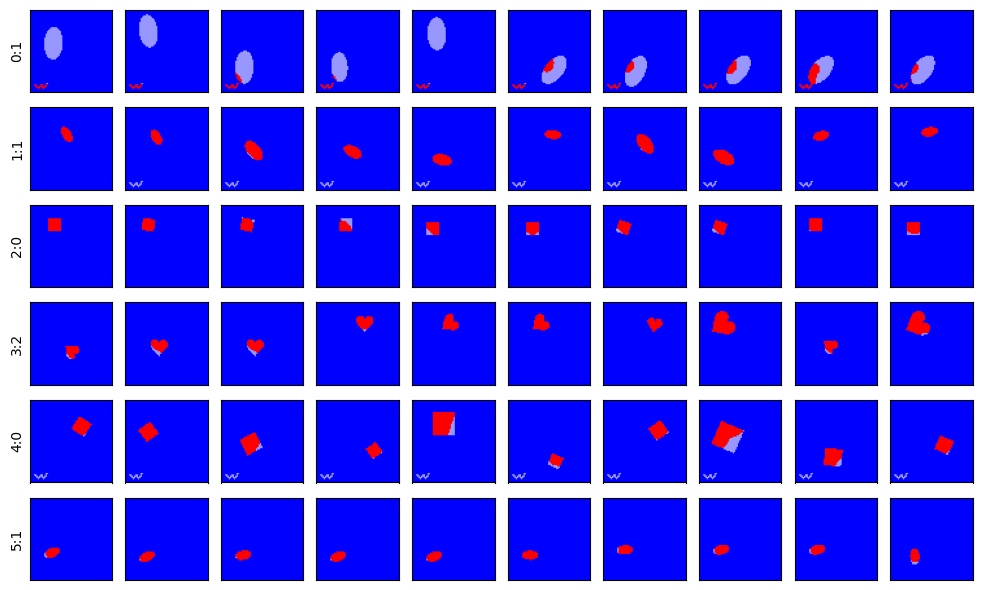

In [12]:
make_all_relevances("linear_layers.0",range(6))

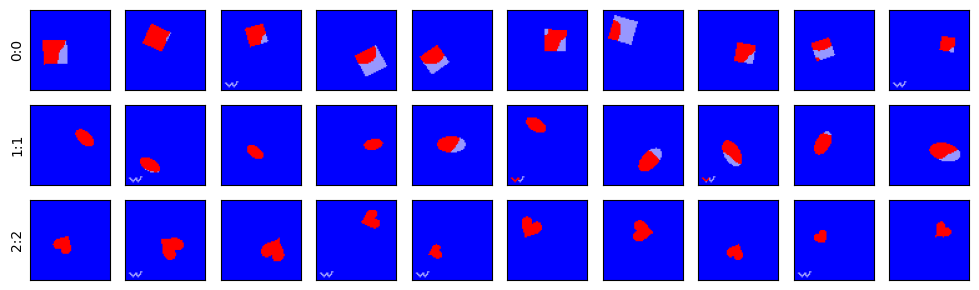

In [13]:
make_all_relevances("linear_layers.2", range(3))

In [8]:
def relevance_for_image(label, image):
    all_refs = {}
    all_refs["sample"] = torch.ones((6,64,64))
    all_refs["sample"][:] = image
    for l in layer_id_map.keys():
        conditions = [{"y": [label], l: [i]} for i in layer_id_map[l]]
        attr = attribution(
            image,
            conditions,
            composite,
            record_layer=layer_names,
        )
        all_refs[f"{l[:4]}_{l[-1]}"] = torch.zeros((6,64,64))
        for h in range(attr.heatmap.shape[0]):
            all_refs[f"{l[:4]}_{l[-1]}"][h] = attr.heatmap[h]

    plot_grid(all_refs, figsize=(6, 6), padding=False)


latents: [ 1  3 20 17 24],
 watermark: False, 
 prediction:1  
 
 convolutional_layers.0: 
 0: 47.09%, 4: 25.04%, 1: 21.72%, 3: 3.29%, 2: 1.77%, 5: 1.09% 
 
 convolutional_layers.2: 
 3: 32.78%, 4: 29.4%, 5: 16.32%, 0: 0.0%, 2: 0.0%, 1: -21.5% 
 
 linear_layers.0: 
 1: 94.2%, 0: 1.76%, 5: 0.0%, 4: 0.0%, 2: 0.0%, 3: -4.04% 
 
 linear_layers.2: 
 1: 100.0%, 0: 0.0%, 2: 0.0% 


/home/lilli/miniconda3/envs/mt/lib/python3.10/site-packages/zennit/image.py:187: RuntimeWarning: invalid value encountered in divide
  array = (array - vmin) / (vmax - vmin)


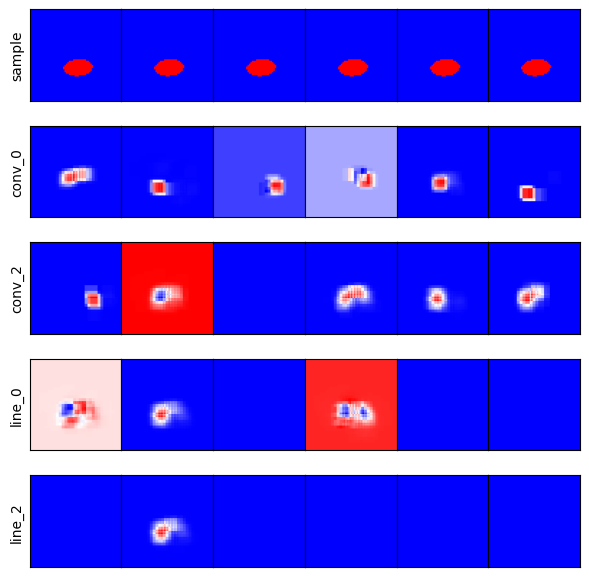

In [9]:
index = np.random.randint(0, 100000)
datum = datasets["test_unbiased"]["ds"][index]
label = datum[1]
img = datum[0]
latents, watermark = datasets["test_unbiased"]["ds"].get_item_info(index)
sample = img.view(1, 1, 64, 64)
sample.requires_grad = True
result_string = ""
output = model(sample)
pred = output.data.max(1, keepdim=True)[1]
res = pred[0][0].tolist()
conditions = [{"y": [res]}]
attr = attribution(sample, conditions, composite, record_layer=layer_names)
for cond_layer in layer_id_map.keys():
    rel_c = cc.attribute(attr.relevances[cond_layer], abs_norm=True)
    # concepts ordered by relevance and their contribution to final classification in percent
    rel_values, concept_ids = torch.topk(rel_c[0], len(layer_id_map[cond_layer]))
    result_string += f'\n \n {cond_layer}: \n {", ".join([str(int(concept_ids[i])) + ": " + str(round(float(rel_values[i])*100, 2)) + "%" for i in range(len(layer_id_map[cond_layer]))])} '
print(
    f'latents: {latents},\n watermark: {watermark}, \n prediction:{res}  {result_string}'
)
relevance_for_image(label, sample)

In [8]:
def get_reference_scores(img, label, layer, neurons):
    conditions = [{ 'y': [label]}]
    attr = attribution(img, conditions, composite, record_layer=layer_names)
    rel_c = cc.attribute(attr.activations[layer], abs_norm=True) # relevances
    return [rel_c[0][i] for i in neurons]

In [9]:
def draw_complete_ref_score_values(size, layers, shape=None):
    variables = []
    while len(variables) < size:
        # test_unbiased, train, no_watermark
        ds = datasets["test_unbiased"]["ds"]
        index = np.random.randint(0, len(ds))
        latents, watermark = ds.get_item_info(index)
        # only specific shape
        img, label = ds[index]
        if shape is not None and label != shape:
            continue
        sample = img.view(1, 1, 64, 64)
        sample.requires_grad = True
        in_variables = []
        for x in layers:
            cond_layer = x[0]
            if cond_layer == "factors":
                res = latents.tolist() + [int(watermark)]
            elif cond_layer == "prediction":
                output = model(sample)
                if len(x[1]) == 1:
                    pred = output.data.max(1, keepdim=True)[1]
                    res = pred[0].tolist()
                else:
                    res = output.data[0].tolist()
            else:
                neurons = x[1]
                res = get_reference_scores(sample, label, cond_layer, neurons)
            in_variables += res

        if not np.all(np.isfinite(in_variables)):
            print(index)
        variables.append(in_variables)
    return np.array(variables, dtype=np.float64)

In [10]:
def no_constants_df(layers, shape=None):
    all_var_names = np.array(
        [f"{nam[0][0:4]}{nam[0][-1]}_{k}" for nam in layers for k in nam[1]]
    )
    data = draw_complete_ref_score_values(5000, layers, shape)
    empty_vars = []
    var_names = all_var_names
    for var in range(len(all_var_names)):
        not_constant = np.where(data[:,var] != data[0,var])[0].shape[0]
        if not_constant < 5: 
            empty_vars.append(var)
    var_names = np.delete(all_var_names, empty_vars)
    data = np.delete(data, empty_vars, axis=1)
    layers = [
        [nam[0], [k for k in nam[1] if f"{nam[0][0:4]}{nam[0][-1]}_{k}" in var_names]]
        for nam in layers
    ]
    # sanity test that variable names are correct
    print(
        f"all variables: {all_var_names.shape},\n non-constant variables: {var_names.shape},\
              \n shape of dataset: {data.shape} \n new layers: \n{layers}\n var names = {var_names}"
    )
    types = np.zeros(data.shape, dtype="int")
    if layers[0][0] == "factors": 
        types[:, :6] = 1
    if var_names[-1] == "predn_class":
        types[:, -1] = 1
    dataframe = pp.DataFrame(data, var_names=var_names, data_type=types)
    return dataframe, var_names, layers

In [11]:
def make_nn_link_assumptions(layers, same_layer=False, all_factors=False):
    link_assumptions = {}
    index = 0
    layerEnd = 0
    for l in range(len(layers)):
        previousEnd = layerEnd
        layerEnd += len(layers[l][1])
        for neuron in layers[l][1]:
            if same_layer or (all_factors and layers[l][0] == "factors"):
                link_assumptions[index] = {}
                for i in range(previousEnd, layerEnd):
                    if i != index:
                        link_assumptions[index][(i, 0)] = "o?o"
                        if i not in link_assumptions:
                            link_assumptions[i] = {}
                        link_assumptions[i][(index, 0)] = "o?o"
            if l + 1 < len(layers):
                if index not in link_assumptions:
                    link_assumptions[index] = {}
                otherneurons = len(layers[l + 1][1])
                if all_factors and l == 0:
                    otherneurons = sum(len(layers[i][1]) for i in range(1, len(layers)))
                for other_neuron in range(otherneurons):
                    othern = layerEnd + other_neuron
                    link_assumptions[index][(othern, 0)] = "-?>"
                    if othern not in link_assumptions:
                        link_assumptions[othern] = {}
                    link_assumptions[othern][(index, 0)] = "<?-"
                index += 1
    return link_assumptions

(10000, 6)
LiNGAM on contemp pair shape --> watermark


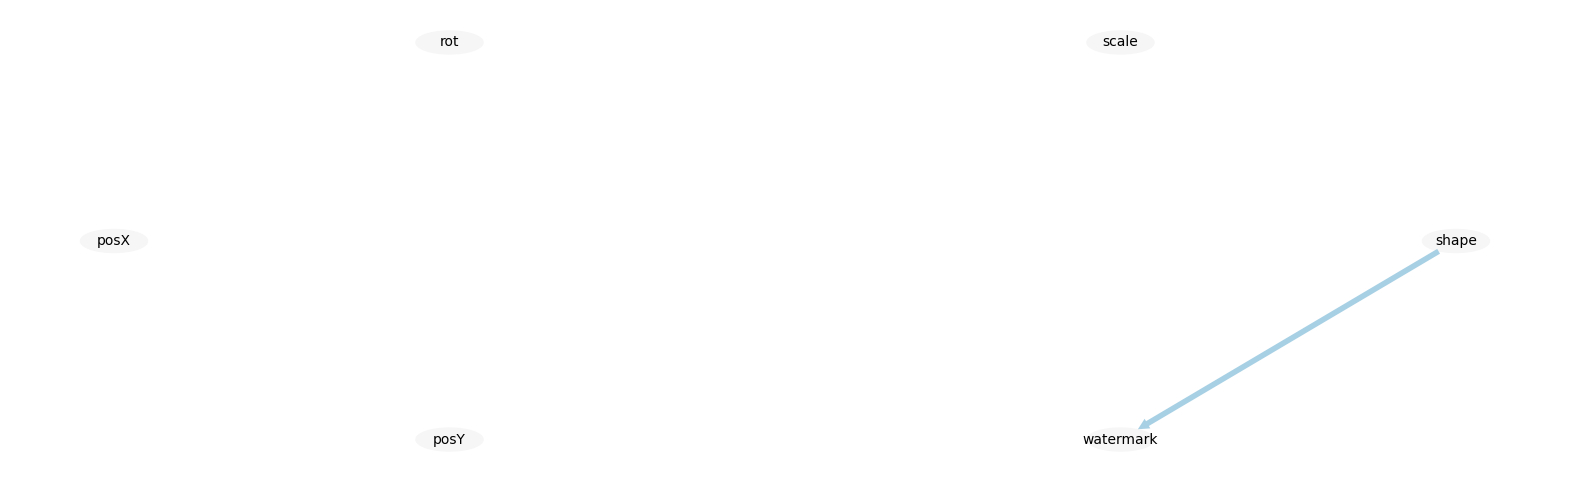

In [14]:
def generating_factors_causal_graph():
    data = []
    for i in range(10000):    
        ds = datasets["train"]["ds"]   
        index = np.random.randint(0, len(ds))
        latents, watermark = ds.get_item_info(index)
        res = latents.tolist() + [int(watermark)]
        data.append(res)
    data = np.array(data, dtype="int")
    print(data.shape)
    var_names = ['shape', 'scale', 'rot', 'posX', 'posY', 'watermark']
    types = np.ones(data.shape, dtype="int")
    dataframe = pp.DataFrame(data, var_names=var_names)#, data_type=types)
    #ci_test = RegressionCI()
    ci_test = RobustParCorr(significance="analytic", )
    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ci_test, verbosity=0)
    results =  pcmci.run_pcalg_non_timeseries_data()
    graph_effects = make_lingam(results, data, var_names)
    tp.plot_graph(
            graph=graph_effects,
            val_matrix=results["val_matrix"],
            save_name=None,
            var_names=var_names,
            figsize=(20, 6),
            arrow_linewidth=4,
            arrowhead_size=30,
            node_size=0.1,
            node_aspect=1,
            label_fontsize=16,
            show_colorbar=False,
        )
generating_factors_causal_graph()

In [13]:
# here you can use all existing layers and accordingly the set of neurons
layers = [
    ["factors", ["shape", "scale", "rot", "posX", "posY", "watermark"]],
    #["convolutional_layers.0", range(6)],
    ["convolutional_layers.2", range(6)],
    ["linear_layers.0", range(6)],
    ["linear_layers.2", range(3)],
    #["prediction", ["rectangle", "ellipse", "heart"]] # ["class"]],  # 
]  # , ["prediction", range(3)]

dataframe, var_names, layers = no_constants_df(layers, 0)

all variables: (21,),
 non-constant variables: (20,),              
 shape of dataset: (5000, 20) 
 new layers: 
[['factors', ['scale', 'rot', 'posX', 'posY', 'watermark']], ['convolutional_layers.2', [0, 1, 2, 3, 4, 5]], ['linear_layers.0', [0, 1, 2, 3, 4, 5]], ['linear_layers.2', [0, 1, 2]]]
 var names = ['facts_scale' 'facts_rot' 'facts_posX' 'facts_posY' 'facts_watermark'
 'conv2_0' 'conv2_1' 'conv2_2' 'conv2_3' 'conv2_4' 'conv2_5' 'line0_0'
 'line0_1' 'line0_2' 'line0_3' 'line0_4' 'line0_5' 'line2_0' 'line2_1'
 'line2_2']


In [14]:
#ci_test = CMIknn(significance='fixed_thres', fixed_thres=0.01)
#ci_test = RobustParCorr(significance="analytic", )
#ci_test = GPDCtorch()
#ci_test = CMIsymb(significance='fixed_thres', fixed_thres=0.4)
#ci_test = RegressionCI(significance='fixed_thres', fixed_thres=0.4)
ci_test = CMIknnMixed(significance='fixed_thres', fixed_thres=0.4)
link_assumptions  = make_nn_link_assumptions(layers, False, True)

pcmci = PCMCI(dataframe=dataframe, cond_ind_test=ci_test, verbosity=0)
results =  pcmci.run_pcmciplus(tau_max=0, pc_alpha=0.01, link_assumptions=link_assumptions)
#results = pcmci.run_pcalg_non_timeseries_data()


KeyboardInterrupt: 

In [ ]:
import networkx as nx


def plot_multipartite(graph_res, layers):
    link_matrix_upper = np.copy(graph_res["graph"])
    link_matrix_upper[:, :, 0] = np.triu(link_matrix_upper[:, :, 0])
    # net = _get_absmax(link_matrix != "")
    net = np.any(link_matrix_upper != "", axis=2)
    G = nx.DiGraph(net)
    node_labels = {}
    for i in G.nodes:
        n = 0
        if i < len(layers[0][1]):
            subset = 0
            layer = layers[0][0]
            n = i
        elif len(layers) > 1 and i < len(layers[0][1]) + len(layers[1][1]):
            subset = 1
            layer = layers[1][0]
            n = i - len(layers[0][1])
        elif len(layers) > 2 and i < len(layers[0][1]) + len(layers[1][1]) + len(
            layers[2][1]
        ):
            subset = 2
            layer = layers[2][0]
            n = i - (len(layers[0][1]) + len(layers[1][1]))
        elif len(layers) > 3 and i < len(layers[0][1]) + len(layers[1][1]) + len(layers[2][1]) + len(
            layers[3][1]
        ):
            subset = 3
            layer = layers[3][0]
            n = i - (len(layers[0][1]) + len(layers[1][1]) + len(layers[2][1]))
        elif len(layers) > 4:
            subset = 4
            layer = layers[4][0]
            n = i - (
                len(layers[0][1])
                + len(layers[1][1])
                + len(layers[2][1])
                + len(layers[3][1])
            )
        else:
            subset = 0
            layer = "what"
            n = i

        G.nodes[i]["subset"] = subset
        G.nodes[i]["layer"] = layer
        G.nodes[i]["name"] = layers[subset][1][n]
        node_labels[i] = f"{layer[:3]}{layer[-1]}_{layers[subset][1][n]}"
    pos = nx.multipartite_layout(G, subset_key="subset")
    edge_color = [results["val_matrix"][i][j][0] for (i, j) in G.edges]
    """ node_pos = {"x": [], "y": []}
    for n in pos.keys():
        node_pos["x"] += [pos[n][0]]
        node_pos["y"] += [pos[n][1]]
    tp.plot_graph(
        graph=results["graph"],
        val_matrix=results["val_matrix"],
        save_name=None,
        var_names=var_names,
        figsize=(20, 6),
        arrow_linewidth=4,
        arrowhead_size=30,
        node_size=0.1,
        node_aspect=1,
        label_fontsize=16,
        node_pos=node_pos,
        show_colorbar=False,
    )
    plt.show() """

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, frame_on=False)
    nx.draw_networkx(
        G,
        ax=ax,
        pos=pos,
        labels=node_labels,
        node_size=1000,
        linewidths=10,
        width=4,
        node_color="#aaaaaa",
        arrowstyle="->",
        arrowsize=20,
        edge_cmap=mpl.cm.bwr,
        edge_color=edge_color,
        connectionstyle="arc3,rad=0.1",
    )

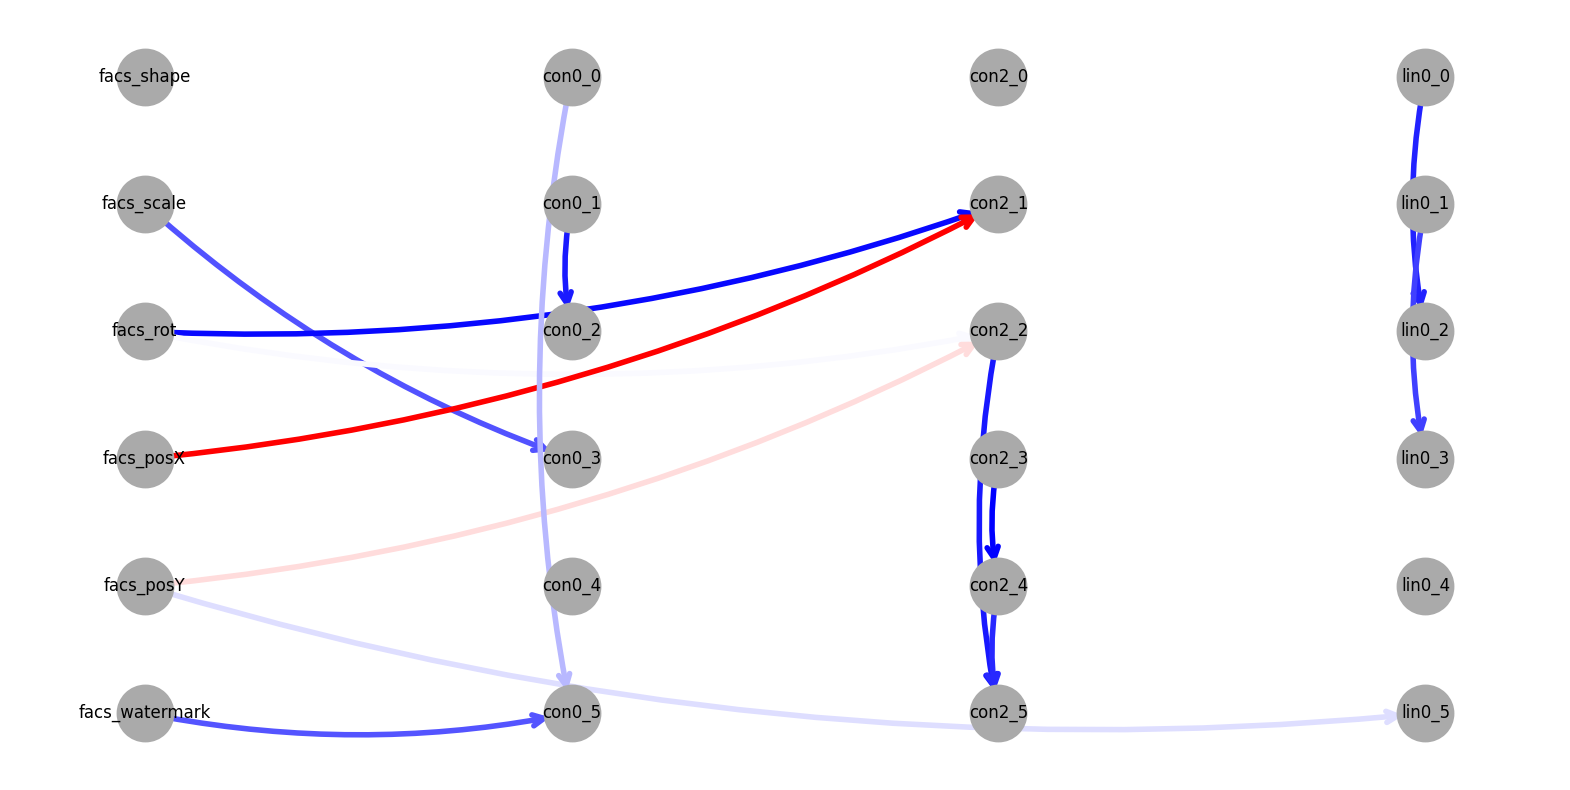

In [ ]:
plot_multipartite(results, layers)

In [37]:

np.save("shape_all_graph.npy", results["graph"])
np.save("shape_all_values.npy", results["val_matrix"])

rectangle_matrix = results["val_matrix"]

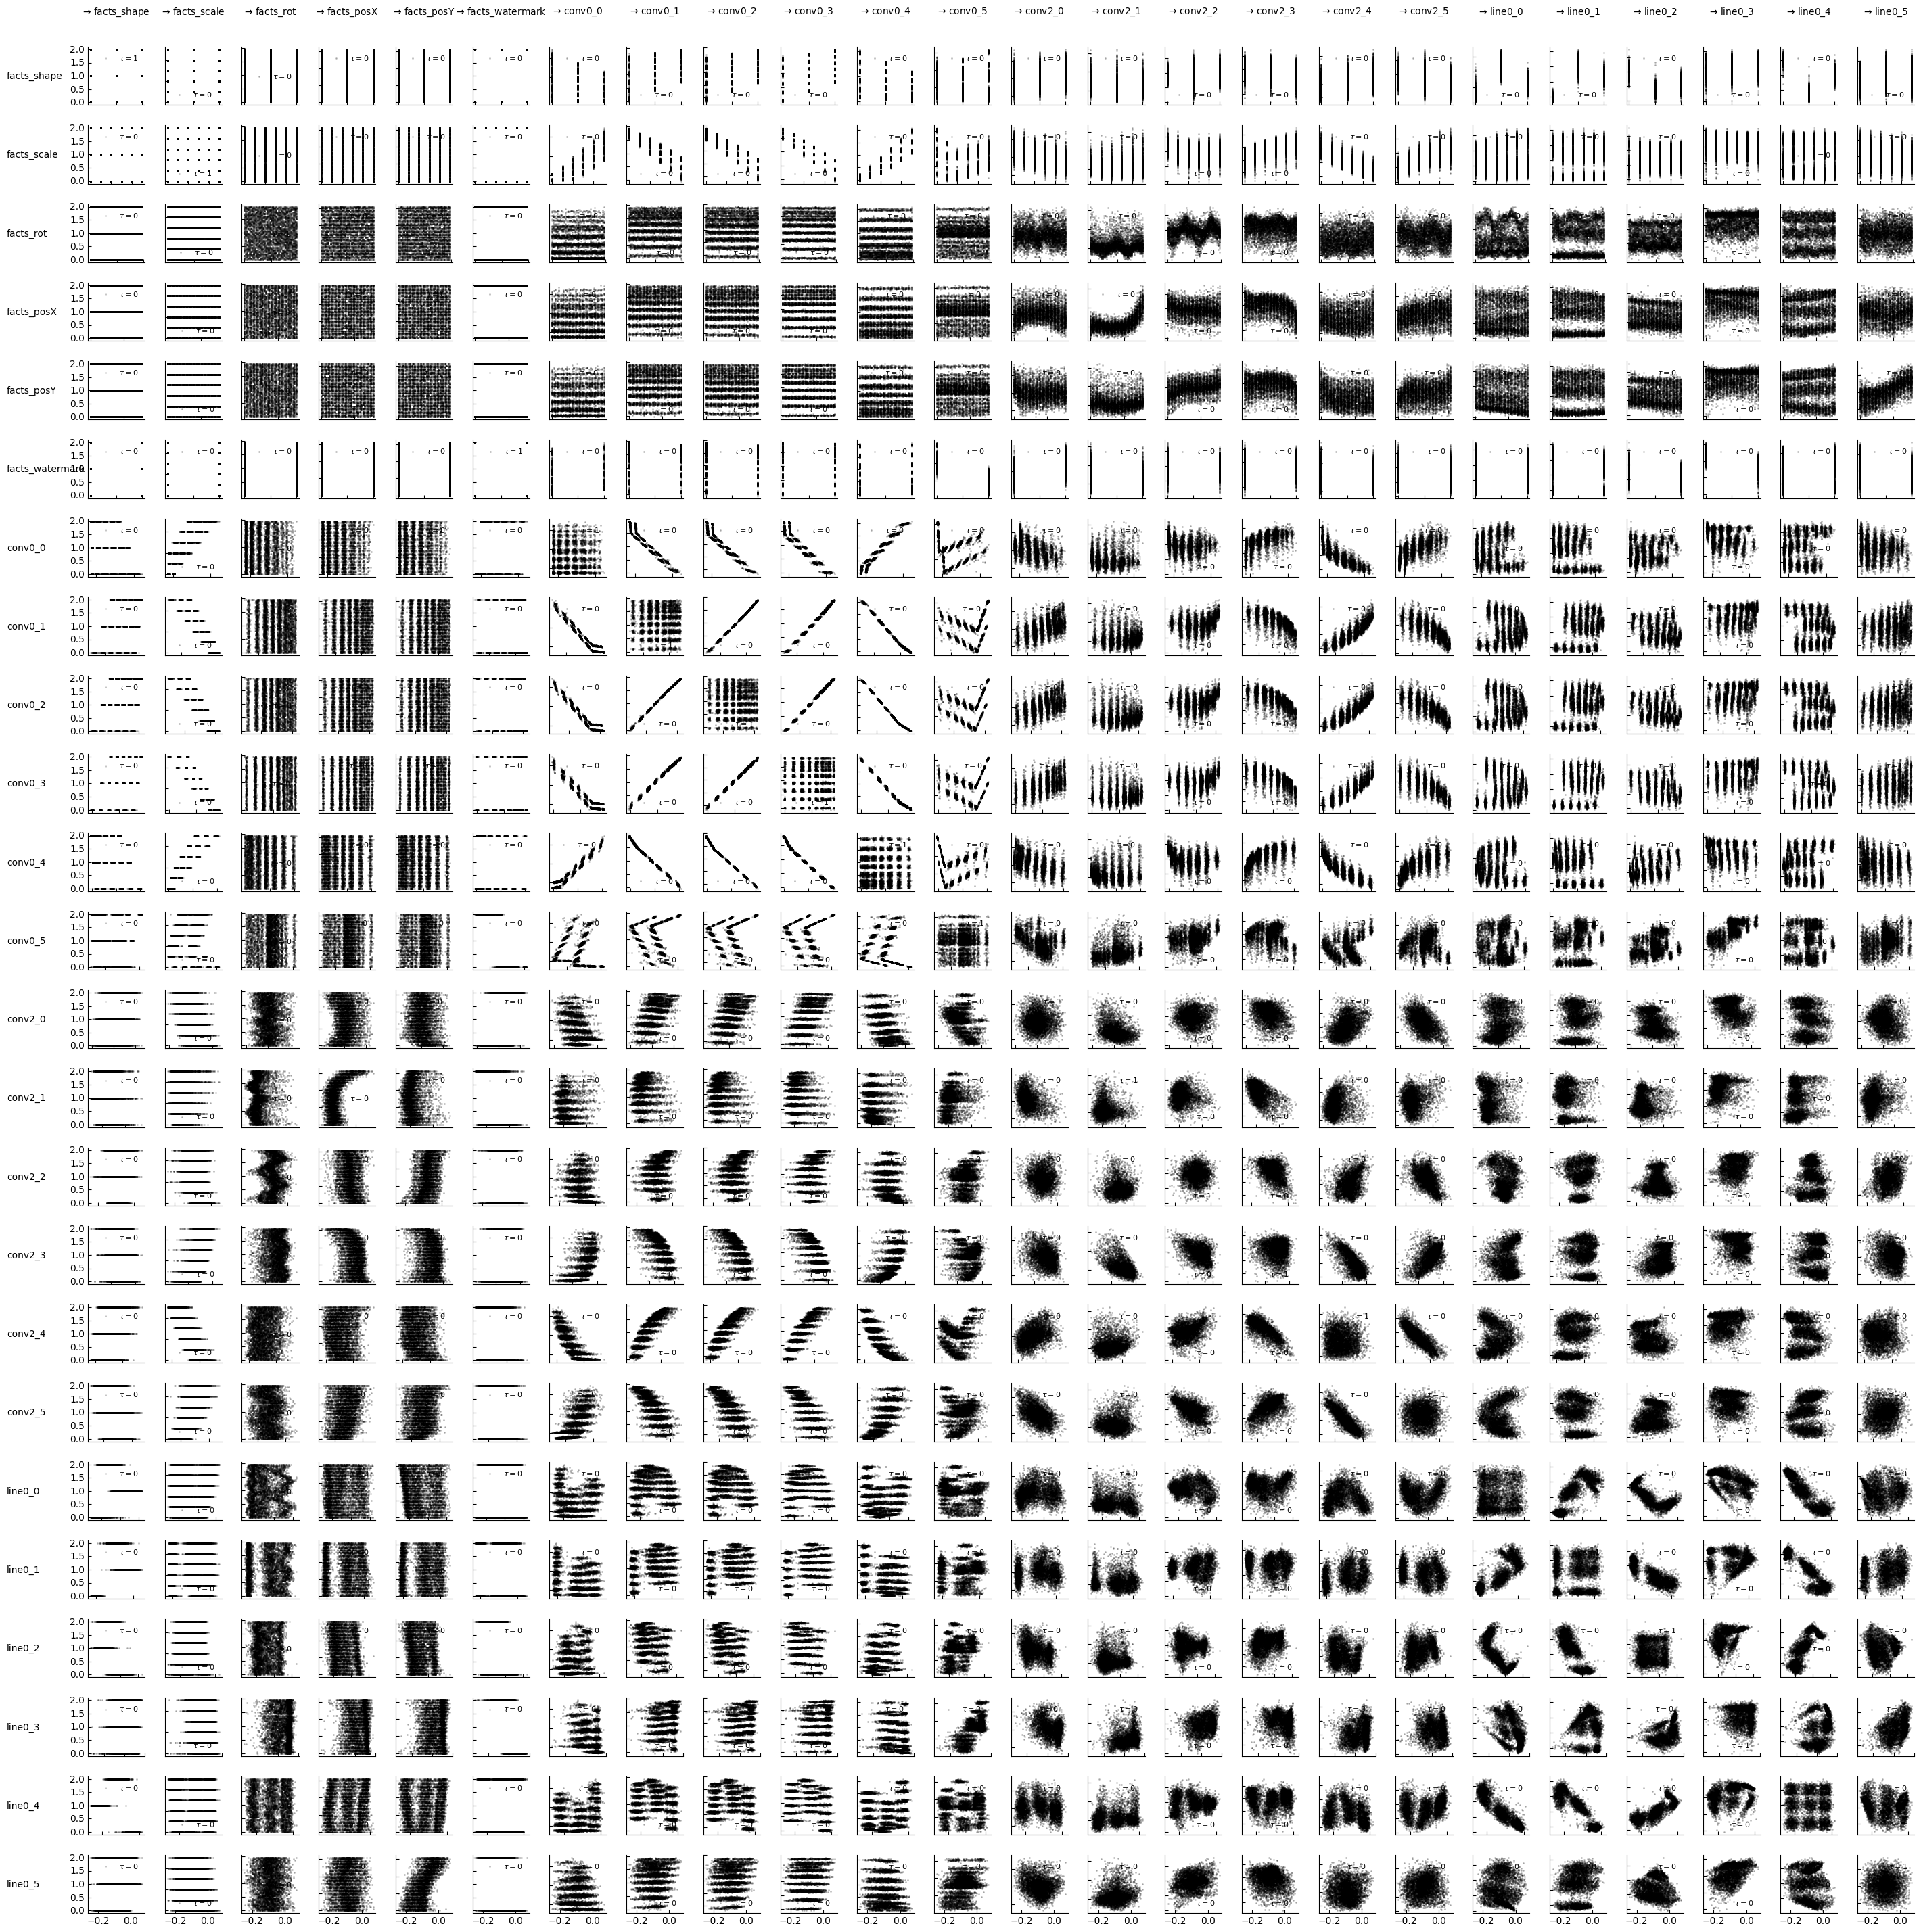

In [47]:
setup_args = {"figsize": (30,30),"label_space_left": 0.05,"label_space_top": 0.03}
tp.plot_scatterplots(dataframe=dataframe, add_scatterplot_args={'matrix_lags':None}, 
                    setup_args=setup_args); plt.show()

In [41]:

from torch.autograd import Variable
import torch.nn.functional as F

def accuracy(model, loader):
    model.eval()
    losses = []
    correct = 0
    with torch.no_grad():
        for item in tqdm(loader):
            data, target = Variable(item[0]), Variable(item[1])
            output = model(data)
            losses.append(F.cross_entropy(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    eval_loss = float(np.mean(losses))
    return eval_loss, 100. * correct / len(loader.dataset)


def accuracy_per_class(model, loader):
    model.eval()
    n_classes = 3
    correct = np.zeros(n_classes, dtype=np.int64)
    wrong = np.zeros(n_classes, dtype=np.int64)
    with torch.no_grad():
        for item in tqdm(loader):
            data, target = Variable(item[0]), Variable(item[1])
            output = model(data)
            preds = output.data.max(dim=1)[1].cpu().numpy().astype(np.int64)
            target = target.data.cpu().numpy().astype(np.int64)
            for label, pred in zip(target, preds):
                if label == pred:
                    correct[label] += 1
                else:
                    wrong[label] += 1
    assert correct.sum() + wrong.sum() == len(loader.dataset)
    return 100. * correct / (correct + wrong)

In [38]:
train_acc = accuracy(model, datasets["train"]["loader"])  

NameError: name 'accuracy' is not defined

In [42]:
train_acc_per_class = accuracy_per_class(model, datasets["train"]["loader"])  
test_biased_acc_per_class = accuracy_per_class(model, datasets["test_biased"]["loader"])  
test_unbiased_acc_per_class = accuracy_per_class(model, datasets["test_unbiased"]["loader"])  
no_watermark_acc_per_class = accuracy_per_class(model, datasets["no_watermark"]["loader"])  

  0%|          | 0/3417 [00:00<?, ?it/s]

100%|██████████| 3417/3417 [01:52<00:00, 30.34it/s]


In [45]:
print(f'train_acc_per_class: {train_acc_per_class} \n test_biased_acc_per_class: {test_biased_acc_per_class} \n test_unbiased_acc_per_class{test_unbiased_acc_per_class} \n no_watermark_acc_per_class: {no_watermark_acc_per_class}')

train_acc_per_class: [99.83257971 99.84236278 99.43862069] 
 test_biased_acc_per_class: [99.83495379 99.8168828  99.37857171] 
 test_unbiased_acc_per_class[99.81694875 98.72518412 98.20964712] 
 no_watermark_acc_per_class: [99.83326586 98.28236852 99.63241379]


In [101]:
accuracy(model, datasets["test_biased"]["loader"])    

100%|██████████| 2344/2344 [01:14<00:00, 31.56it/s]


(0.009844694689109205, 99.67666666666666)

In [68]:
accuracy(model, datasets["test_unbiased"]["loader"])    

  0%|          | 0/2344 [00:00<?, ?it/s]

100%|██████████| 2344/2344 [01:59<00:00, 19.63it/s]


(0.0303823177177962, 98.91833333333334)

In [103]:
accuracy(model, datasets["no_watermark"]["loader"])   

100%|██████████| 3417/3417 [01:44<00:00, 32.83it/s]


(0.0212135140075849, 99.24693560190268)